## Sztuczne sieci neuronowe - laboratorium 2

### Poszukiwanie parametrów modelu

In [1]:
import torch

Załóżmy, że mamy dwa termometry:
- jeden mierzy temperaturę w stopniach Celsjusza
- drugi mierzy temperaturę w nieznanej nam skali, ale jest bardzo ładny i chcemy go powiesić na ścianie

Zanim to zrobimy, chcemy się dowiedzieć, jak przeliczać wskazania drugiego termometru na stopnie Celsjusza.
Spróbujemy znaleźć "wzór" tego przekształcenia na podstawie pomiarów dokonanych obydwoma termometrami.

In [2]:
data_celsius = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
data_unknown = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

#### Ćwiczenie
Zwizualizuj dane pomiarowe jako punkty na płaszczyźnie (użyj `plt.scatter()`), na osi poziomej umieszczając temperaturę w nieznanej skali, a na osi pionowej - temperaturę w stopniach Celsjusza.

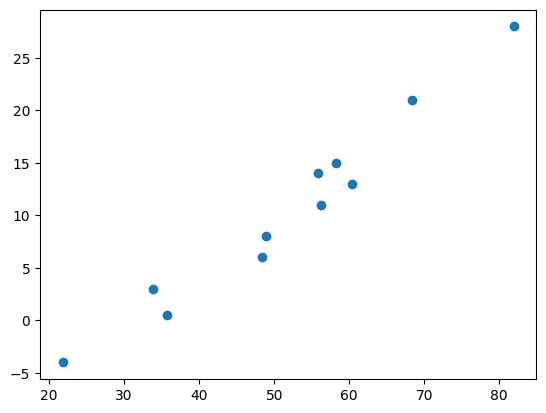

In [3]:
import matplotlib.pyplot as plt

plt.scatter(data_unknown, data_celsius)

#### Ćwiczenie
Stwórz tensory `t_c` (temp. w stopniach Celsjusza) i `t_u` (temp. w skali "unknown") na podstawie danych.

In [4]:
t_c = torch.tensor(data_celsius)
t_u = torch.tensor(data_unknown)

#### Ćwiczenie
Zaproponuj na podstawie powyższej wizualizacji danych, jakiego modelu (możliwie prostego) użyć w tym zagadnieniu.
Podaj "wzór" modelu i zdefiniuj funkcję `model(t_u, ...)` przekształcającą tensor wejściowy `t_u` w predykcję (niech funkcja zwróci tensor). Jakie będą parametry tego modelu?

In [5]:
def model(t_u, w, b):
    return w * t_u + b

#### Ćwiczenie
Wybierz funkcję straty typową dla zadania regresji i zaimplementuj ją jako funkcję `loss_fn()`. Niech przyjmuje dwa argumenty - tensor predykcji `t_p` oraz tensor prawdziwych wartości `t_c`. Niech funkcja zwraca wartość funkcji straty (skalar / liczbę).

In [6]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

#### Ćwiczenie
Zainicjalizuj parametry modelu jako tensory "zero-wymiarowe" (skalary) `w` i `b` o wartościach odpowiednio 1 i 0.
Wykorzystaj w tym celu `torch.zeros()` i `torch.ones()` podając jako argument: `()`

Oblicz tensor predykcji modelu dla zadanych parametrów oraz wartość funkcji straty używając zaimplementowanych wyżej funkcji.

In [7]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
loss = loss_fn(t_p, t_c)
print(t_p)
print(loss)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
tensor(1763.8848)


### Badanie wpływu parametrów na wartość funkcji straty

Powyżej obliczyliśmy wartość funkcji straty przy określonym zestawie parametrów modelu. Sprawdźmy teraz, co się stanie, gdy każdy z tych parametrów (niezależnie od siebie) zwiększymy lub zmniejszymy o pewną wartość `delta`. Pozwoli to oszacować współczynniki zmiany wartości funkcji straty przy zmianie wartości parametru (dla każdego z parametrów z osobna).

Na podstawie tych współczynników, będziemy próbowali następnie zmienić wartości parametrów w taki sposób (zmniejszyć lub zwiększyć), aby  "podążać w kierunku" malejącej funkcji straty. Jeśli współczynnik dla danego parametru wyjdzie ujemny, to znaczy, że zwiększenie tego parametru zmniejsza funkcję straty, a zatem ten parametr należy jeszcze zwiększyć. Analogicznie, gdy współczynnik jest dodatni, zmniejszamy wartość tego parametru.

Należy jednak uważać, aby pojedyncza zmiana parametru nie była ani zbyt mała, ani zbyt duża. Wielkość "kroku" kontroluje się typowo stosując tzw. stałą uczącą (ang. `learning_rate`). Stała ucząca jest jednym z najważniejszych hiperparametrów modeli (np. sieci neuronowych).

#### Ćwiczenie

Uzupełnij poniższy kod i oblicz współczynniki zmiany wartości funkcji straty ze względu na poszczególne parametry modelu. Przyjmuj `delta` = 0.1

In [8]:
delta = 0.1

# ZASTĄP WYSTĄPIENIA SŁOWA "None" WŁASNYM

loss_w_plus_delta = loss_fn(model(t_u, w + delta, b), t_c)
loss_w_minus_delta = loss_fn(model(t_u, w - delta, b), t_c)

loss_b_plus_delta = loss_fn(model(t_u, w, b + delta), t_c)
loss_b_minus_delta = loss_fn(model(t_u, w, b - delta), t_c)

loss_rate_of_change_w = (loss_w_plus_delta - loss_w_minus_delta) / (2*delta)

loss_rate_of_change_b = (loss_b_plus_delta - loss_b_minus_delta) / (2*delta)

print(loss_rate_of_change_w)
print(loss_rate_of_change_b)

tensor(4517.2974)
tensor(82.5995)


#### Ćwiczenie
Zaktualizuj (nadpisz) wartości parametrów odejmując od poprzedniej wartości współczynnik zmiany funkcji straty przemnożony przez tzw. `learning_rate` - stałą uczącą. Niech `learning_rate` wynosi 0.01.

In [9]:
learning_rate = 0.01

w = w - learning_rate * loss_rate_of_change_w
b = b - learning_rate * loss_rate_of_change_b
print(w)
print(b)

tensor(-44.1730)
tensor(-0.8260)


### Pochodna funkcji

Pochodna funkcji jest miarą szybkości zmian wartości funkcji względem zmian jej argumentów. Obliczając pochodną funkcji w punkcie, liczymy w zasadzie współczynnik jak wyżej, przyjmując nieskończenie małe `delta`. Interesuje nas pochodna funkcji straty względem poszczególnych parametrów modelu - gradient.

Do obliczania pochodnych funkcji złożonych wykorzystuje się tzw. regułę łańcuchową ("chain rule").

Funkcja straty `L` jest funkcją predykcji modelu `t_p`. `t_p` zależy od parametrów modelu (`w` i `b`).
Pochodna funkcji straty ze względu na parametr `w` może być obliczona następująco:

`dL/dw = (dL/dtp) * (dtp/dw)`

Analogicznie dla parametru `b`:

`dL/db = (dL/dtp) * (dtp/db)`

#### Ćwiczenie

Wykorzystaj swoją wiedzę z analizy matematycznej, aby napisać funkcję `dloss_fn` obliczającą pochodną funkcji straty względem predykcji (na podstawie zaimplementowanej wcześniej `loss_fn` - błędu średniokwadratowego). Będzie to człon `dL/dtp` w powyższym wzorze.

Tymczasowo pomiń we wzorze obliczanie średniej - zrobimy to w odpowiednim miejscu.

In [10]:
def dloss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs

#### Ćwiczenie
Napisz funkcje `dmodel_dw()` oraz `dmodel_db()` przyjmujące jako argumenty: tensor wejściowy `t_u` i parametry modelu (`w` i `b`), a zwracające pochodne predykcji modelu względem parametrów (drugi człon z chain rule, odpowiednio `dtp/dw` i `dtp/db`).
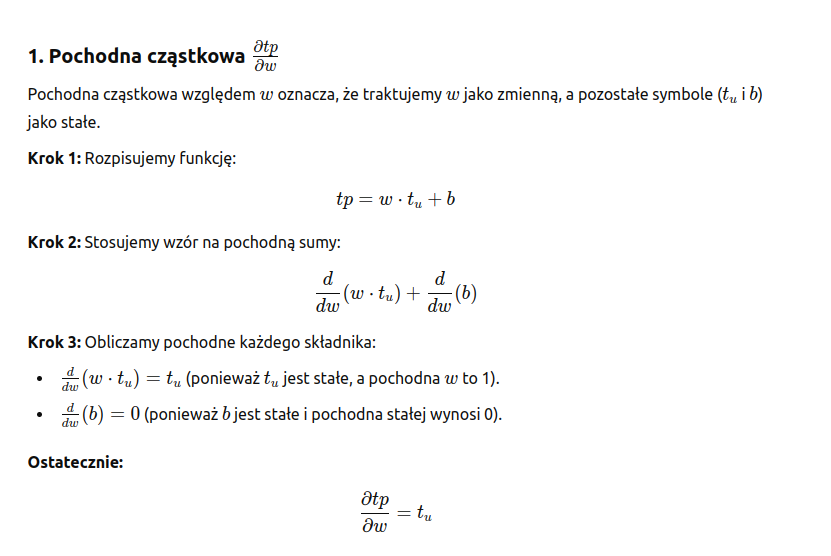

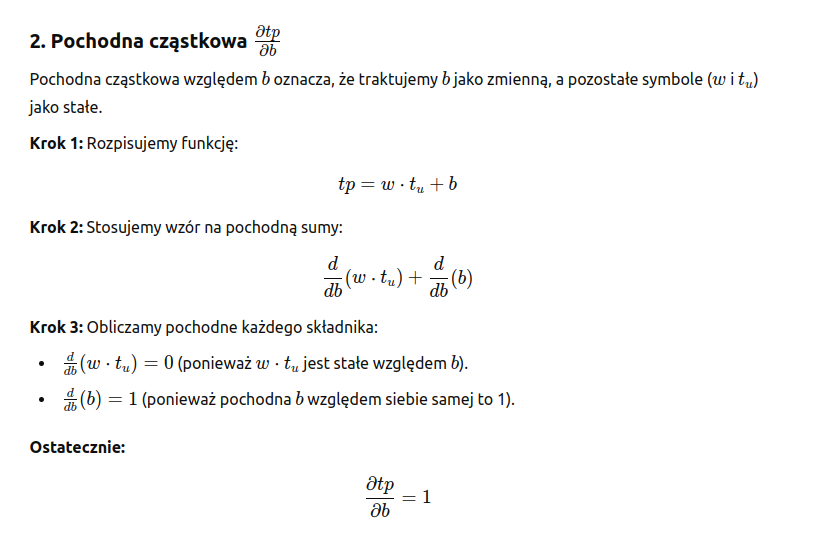

In [11]:
def dmodel_dw(t_u, w, b):
    return t_u

In [12]:
def dmodel_db(t_u, w, b):
    return 1.0

#### Ćwiczenie
Uzupełnij poniższy kod, aby obliczyć gradient funkcji straty, czyli wektor (tensor) pochodnych względem parametrów modelu).

Zwróć uwagę na użycie funkcji `mean()` w zwracanym tensorze.

In [13]:
def grad_fn(t_u, t_c, t_p, w, b):
    dL_dtp = -2 * (t_c - t_p)
    dL_dw = dL_dtp * dmodel_dw(t_u, w, b)
    dL_db = dL_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dL_dw.mean(), dL_db.mean()])

### Algorytm najszybszego spadku

Gradient (jako wektor pochodnych cząstkowych) wskazuje (wielowymiarowy) kierunek najszybszego wzrostu funkcji.

Algorytm najszybszego spadku (ang. gradient descent) jest iteracyjnym algorytmem optymalizacji funkcji (straty), w którym w każdej iteracji aktualizujemy parametry "podążając" w kierunku przeciwnym do gradientu (wektor o przeciwnym zwrocie) - a więc w kierunku najszybszego spadku.

Jest on realizowany przez poniższy kod.

In [14]:
def training_loop(n_iters, learning_rate, params, t_u, t_c):
    for iteration in range(1, n_iters+1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        # tzw. "vanilla" gradient descent
        params = params - learning_rate * grad

    print('After iteration %d, Loss %f' % (iteration, float(loss)))

    return params

#### Ćwiczenie
Uruchom funkcję `training_loop` dla 100 iteracji, przy `learning_rate` równym 0.01, inicjalizując parametry `w` i `b` wartościami 1.0 i 0.0.

Zaobserwuj, co się stało, i pomyśl, dlaczego. Co się stało i dlaczego?

In [15]:
params = torch.tensor([1.0, 0.0])
training_loop(n_iters = 100, learning_rate = learning_rate, params = params, t_u = t_u, t_c = t_c)

After iteration 100, Loss nan


tensor([nan, nan])

Po 100 iteracjach funkcja zwróciła wartość straty nan. Oznacza to, że wartość funkcji straty przekroczyła zakres liczb zmiennoprzecinkowych. Wartość learning_rate była zbyt duża, co spowodowało, że algorytm "przeskoczył" minimum funkcji straty.

#### Ćwiczenie
Uruchom `training_loop` dla 100 iteracji zmniejszając `learning_rate` do 0.0001. Co się zmieniło?

In [16]:
learning_rate = 0.0001
training_loop(n_iters = 100, learning_rate = learning_rate, params = params, t_u = t_u, t_c = t_c)

After iteration 100, Loss 29.022667


tensor([ 0.2327, -0.0438])

Dzięki dostosowaniu wartości learning_rate algorytm zbiegł do minimum funkcji straty. Wartość straty po 100 iteracjach wynosi w przybliżeniu 29.023.

### Normalizacja danych

Poza `learning_rate`, we wzorze na aktualizację parametrów modelu występuje także gradient. Przyjrzyjmy się zawartości zmiennej `grad` w kolejnych iteracjach.

Widzimy, że w początkowych iteracjach treningu gradient dla parametru `w` jest znacząco większy (ok. 50 razy) niż dla `b`. Wskazuje to na fakt, że parametry nie są w tej samej skali i trudno dobrać do nich ten sam `learning_rate`.

Uwaga:
Bardziej złożone algorytmy optymalizacji radzą sobie częściowo z tym problemem - wrócimy do tego na kolejnych zajęciach.

In [17]:
def training_loop_print_grad(n_iters, learning_rate, params, t_u, t_c):
    for iteration in range(1, n_iters+1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        print(grad)
        # tzw. "vanilla" gradient descent
        params = params - learning_rate * grad

    print('After iteration %d, Loss %f' % (iteration, float(loss)))

    return params

In [18]:
training_loop_print_grad(n_iters = 100,
              learning_rate = 1e-4,
              params = params,
              t_u = t_u,
              t_c = t_c)

tensor([4517.2964,   82.6000])
tensor([1859.5492,   35.7843])
tensor([765.4666,  16.5122])
tensor([315.0790,   8.5787])
tensor([129.6733,   5.3127])
tensor([53.3496,  3.9682])
tensor([21.9304,  3.4148])
tensor([8.9965, 3.1869])
tensor([3.6721, 3.0930])
tensor([1.4803, 3.0544])
tensor([0.5781, 3.0384])
tensor([0.2066, 3.0318])
tensor([0.0537, 3.0291])
tensor([-0.0093,  3.0279])
tensor([-0.0352,  3.0274])
tensor([-0.0459,  3.0272])
tensor([-0.0502,  3.0270])
tensor([-0.0520,  3.0270])
tensor([-0.0528,  3.0269])
tensor([-0.0531,  3.0268])
tensor([-0.0532,  3.0268])
tensor([-0.0533,  3.0267])
tensor([-0.0533,  3.0267])
tensor([-0.0533,  3.0266])
tensor([-0.0533,  3.0266])
tensor([-0.0533,  3.0265])
tensor([-0.0533,  3.0265])
tensor([-0.0532,  3.0264])
tensor([-0.0533,  3.0264])
tensor([-0.0533,  3.0263])
tensor([-0.0532,  3.0262])
tensor([-0.0533,  3.0262])
tensor([-0.0533,  3.0261])
tensor([-0.0533,  3.0261])
tensor([-0.0532,  3.0260])
tensor([-0.0533,  3.0260])
tensor([-0.0533,  3.0259])

tensor([ 0.2327, -0.0438])

Rozwiązaniem problemu może być odpowiednia normalizacja wejść do modelu. Temat ten będzie szerzej omawiany w późniejszym czasie, na teraz spróbujmy jedynie przeskalować wejścia zmniejszając je 10-krotnie (`t_u * 0.1`) . Teraz model nie "wybuchnie" nawet dla `learning_rate` równego 0.01.

In [19]:
training_loop_print_grad(n_iters = 100,
              learning_rate = 1e-2,
              params = params,
              t_u = t_u * 0.1,
              t_c = t_c)

tensor([-77.6140, -10.6400])
tensor([-30.8623,  -2.3864])
tensor([-12.4631,   0.8587])
tensor([-5.2218,  2.1327])
tensor([-2.3715,  2.6310])
tensor([-1.2492,  2.8241])
tensor([-0.8071,  2.8970])
tensor([-0.6325,  2.9227])
tensor([-0.5633,  2.9298])
tensor([-0.5355,  2.9295])
tensor([-0.5240,  2.9264])
tensor([-0.5190,  2.9222])
tensor([-0.5165,  2.9175])
tensor([-0.5150,  2.9126])
tensor([-0.5138,  2.9077])
tensor([-0.5129,  2.9028])
tensor([-0.5120,  2.8979])
tensor([-0.5111,  2.8930])
tensor([-0.5102,  2.8881])
tensor([-0.5093,  2.8832])
tensor([-0.5084,  2.8783])
tensor([-0.5076,  2.8734])
tensor([-0.5067,  2.8685])
tensor([-0.5059,  2.8636])
tensor([-0.5050,  2.8588])
tensor([-0.5042,  2.8539])
tensor([-0.5033,  2.8490])
tensor([-0.5024,  2.8442])
tensor([-0.5016,  2.8394])
tensor([-0.5007,  2.8346])
tensor([-0.4999,  2.8297])
tensor([-0.4990,  2.8249])
tensor([-0.4982,  2.8201])
tensor([-0.4973,  2.8153])
tensor([-0.4965,  2.8106])
tensor([-0.4957,  2.8058])
tensor([-0.4948,  2.80

tensor([ 2.7553, -2.5162])

#### Ćwiczenie

Uruchom `training_loop` (nie ma potrzeby wypisywania gradientów) dla większej liczby iteracji - sparwdź np. 1000, 2000, 5000, 10000. Niech `learning_rate` wynosi 0.01. Pamiętaj o przeskalowaniu wejść do modelu (`t_u * 0.1`).

Przypisz wartości parametrów (zwracane przez funkcję) do zmiennej `params`.

In [20]:
params=training_loop(n_iters = 5000, learning_rate = 0.01, params = params, t_u = t_u * 0.1, t_c = t_c)

After iteration 5000, Loss 2.927648


#### Ćwiczenie

Uruchom poniższy kod, aby zwizualizować dopasowanie modelu do danych (przy znalezionych parametrach).

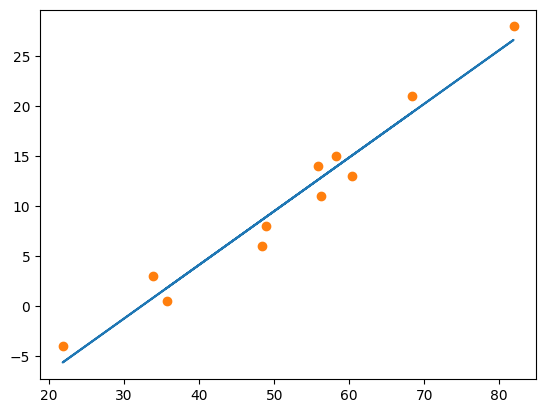

In [21]:
import matplotlib.pyplot as plt

t_p = model(t_u * 0.1, *params)

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [22]:
print(*params)

tensor(5.3671) tensor(-17.3012)


#### Ćwiczenie
1. Jaki będzie ostatecznie "wzór" przeliczający skalę "unknown" na stopnie Celsjusza?
t_p = t_u * 0.1 * 5.367 + 32.0
2. Czy wiesz, jaka skala kryje się pod "unknown"?
Skala Fahrenheita
3. Dla jakiej temperatury wartość na obu skalach będzie taka sama?
Dla temperatury -40 stopni

### Wnioski
Dzięki laboratorium miałem okazję lepiej poznać działanie prostych regresji liniowych, nareszcie zrozumiałem, na czym polega funkcja straty oraz nabrałem większej pewności co do samodzielnego pisania tych metod.